In [1]:
# install: tqdm (progress bars)
!pip install tqdm
!pip install torchvision

import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


## Load the data (CIFAR-10)

In [2]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
train_dl = make_loader(TensorDataset(X_tr, Y_tr))
test_dl = make_loader(TensorDataset(X_te, Y_te))

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [3]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50, printer = True):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    iterator = tqdm(train_dl) if printer else train_dl
    for i, (xB, yB) in enumerate(iterator):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

In [4]:
## Define model

In [4]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [5]:
## Train

In [5]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt, k = 400, printer = False)
    test_loss, test_acc = evaluate(model, test_dl)
    
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')

Starting Epoch 0
Epoch 0:	 Train Loss: 2.575 	 Train Acc: 0.292	 Test Acc: 0.366
Starting Epoch 1
Epoch 1:	 Train Loss: 1.470 	 Train Acc: 0.464	 Test Acc: 0.408
Starting Epoch 2
Epoch 2:	 Train Loss: 1.193 	 Train Acc: 0.572	 Test Acc: 0.573
Starting Epoch 3
Epoch 3:	 Train Loss: 1.006 	 Train Acc: 0.647	 Test Acc: 0.638
Starting Epoch 4
Epoch 4:	 Train Loss: 0.856 	 Train Acc: 0.702	 Test Acc: 0.612
Starting Epoch 5
Epoch 5:	 Train Loss: 0.735 	 Train Acc: 0.746	 Test Acc: 0.529
Starting Epoch 6
Epoch 6:	 Train Loss: 0.633 	 Train Acc: 0.781	 Test Acc: 0.728
Starting Epoch 7
Epoch 7:	 Train Loss: 0.554 	 Train Acc: 0.811	 Test Acc: 0.675
Starting Epoch 8
Epoch 8:	 Train Loss: 0.479 	 Train Acc: 0.836	 Test Acc: 0.767
Starting Epoch 9
Epoch 9:	 Train Loss: 0.413 	 Train Acc: 0.859	 Test Acc: 0.800
Starting Epoch 10
Epoch 10:	 Train Loss: 0.355 	 Train Acc: 0.879	 Test Acc: 0.745
Starting Epoch 11
Epoch 11:	 Train Loss: 0.309 	 Train Acc: 0.898	 Test Acc: 0.760
Starting Epoch 12
Epoch 

## Flipping an Image

7


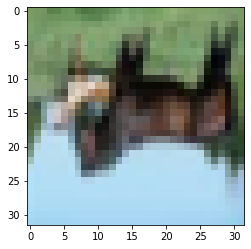

In [6]:
idx = 12
img = torch.flip(train_dl.dataset.tensors[0][idx], [1])
plt.imshow(np.transpose(np.array(img), (1, 2, 0)))
print(np.array(train_dl.dataset.tensors[1][idx]))

def plot_image(img):
    plt.imshow(np.transpose(np.array(img), (1, 2, 0)))
    plt.show()

In [7]:
# Flipping images in test set
X_te_flipped = torch.flip(X_te, [2])

test_dl_flipped = make_loader(TensorDataset(X_te_flipped, Y_te))

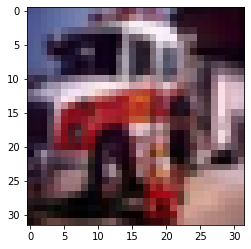

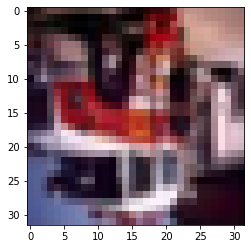

tensor(9)


In [8]:
idx=1231
plot_image(X_te[idx])
plot_image(X_te_flipped[idx])
print(Y_te[idx])

In [9]:
test_loss, test_acc = evaluate(model, test_dl_flipped)

In [10]:
print("Original Model's Flipped Test Results: ", test_loss, test_acc)

Original Model's Flipped Test Results:  2.9914810546875 0.4196


In [11]:
# Organize the test data by class
classes = {}
for i in range(10):
    classes[i] = []

for idx, y in enumerate(Y_te):
    classes[int(y)].append(idx)
    
for label in classes:
    idxs = np.array(classes[label])
    X_temp = X_te[idxs]
    X_temp_flipped = X_te_flipped[idxs]
    Y_temp = Y_te[idxs]
    temp_dl = make_loader(TensorDataset(X_temp, Y_temp))
    temp_dl_flipped = make_loader(TensorDataset(X_temp_flipped, Y_temp))
    _, test_acc = evaluate(model, temp_dl)
    _, test_acc_flipped = evaluate(model, temp_dl_flipped)
    print(f'Class {label} \t Test Accuracy: {test_acc:.3f} \t Flipped Test Accuracy: {test_acc_flipped:.3f}' + 
          f'\t Accuracy Drop: {test_acc - test_acc_flipped:.3f}')

Class 0 	 Test Accuracy: 0.861 	 Flipped Test Accuracy: 0.732	 Accuracy Drop: 0.129
Class 1 	 Test Accuracy: 0.937 	 Flipped Test Accuracy: 0.335	 Accuracy Drop: 0.602
Class 2 	 Test Accuracy: 0.781 	 Flipped Test Accuracy: 0.324	 Accuracy Drop: 0.457
Class 3 	 Test Accuracy: 0.760 	 Flipped Test Accuracy: 0.489	 Accuracy Drop: 0.271
Class 4 	 Test Accuracy: 0.835 	 Flipped Test Accuracy: 0.444	 Accuracy Drop: 0.391
Class 5 	 Test Accuracy: 0.745 	 Flipped Test Accuracy: 0.423	 Accuracy Drop: 0.322
Class 6 	 Test Accuracy: 0.901 	 Flipped Test Accuracy: 0.742	 Accuracy Drop: 0.159
Class 7 	 Test Accuracy: 0.871 	 Flipped Test Accuracy: 0.115	 Accuracy Drop: 0.756
Class 8 	 Test Accuracy: 0.917 	 Flipped Test Accuracy: 0.241	 Accuracy Drop: 0.676
Class 9 	 Test Accuracy: 0.901 	 Flipped Test Accuracy: 0.351	 Accuracy Drop: 0.550


## Training a more robust model

Ideas: 
 - Train with flipped/rotated images
 - More powerful adversarial training? Although this might not help much since we are not testing on these kinds of adversaries 

In [12]:
X_tr_flipped = torch.flip(X_tr, [2])

X_tr_combined = torch.cat([X_tr, X_tr_flipped])

Y_tr_combined = torch.cat([Y_tr, Y_tr])

train_combined_dl = make_loader(TensorDataset(X_tr_combined, Y_tr_combined))

In [13]:
model_combined = make_cnn()
opt = torch.optim.SGD(model_combined.parameters(), lr=0.1)
epochs = 20
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model_combined, train_combined_dl, opt, k = 800, printer = False)
    test_loss, test_acc = evaluate(model_combined, test_dl)
    test_loss_flipped, test_acc_flipped = evaluate(model_combined, test_dl_flipped)
    
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
          f'Test Acc: {test_acc:.3f}\t Test Acc Flipped: {test_acc_flipped:.3f}')

Starting Epoch 0
Epoch 0:	 Train Loss: 2.117 	 Train Acc: 0.362	 Test Acc: 0.318	 Test Acc Flipped: 0.320
Starting Epoch 1
Epoch 1:	 Train Loss: 1.209 	 Train Acc: 0.570	 Test Acc: 0.326	 Test Acc Flipped: 0.330
Starting Epoch 2
Epoch 2:	 Train Loss: 0.955 	 Train Acc: 0.663	 Test Acc: 0.463	 Test Acc Flipped: 0.471
Starting Epoch 3
Epoch 3:	 Train Loss: 0.798 	 Train Acc: 0.720	 Test Acc: 0.192	 Test Acc Flipped: 0.202
Starting Epoch 4
Epoch 4:	 Train Loss: 0.681 	 Train Acc: 0.762	 Test Acc: 0.374	 Test Acc Flipped: 0.385
Starting Epoch 5
Epoch 5:	 Train Loss: 0.583 	 Train Acc: 0.797	 Test Acc: 0.606	 Test Acc Flipped: 0.610
Starting Epoch 6
Epoch 6:	 Train Loss: 0.504 	 Train Acc: 0.825	 Test Acc: 0.549	 Test Acc Flipped: 0.544
Starting Epoch 7
Epoch 7:	 Train Loss: 0.430 	 Train Acc: 0.851	 Test Acc: 0.674	 Test Acc Flipped: 0.671
Starting Epoch 8
Epoch 8:	 Train Loss: 0.363 	 Train Acc: 0.876	 Test Acc: 0.523	 Test Acc Flipped: 0.517
Starting Epoch 9
Epoch 9:	 Train Loss: 0.292 	

## Randomizing Labels in the Dataset

In [5]:
def randomize_labels(labels, p):
    rand = torch.where(torch.rand(size=labels.shape) < p, torch.tensor([1]), torch.tensor([0])) 
    return rand * torch.randint(low=0, high=10, size=labels.shape) + (1 - rand) * labels

In [6]:
p_vals = [0, 0.5, 1.0]
training_labels = []
testing_labels = []
for p in p_vals:
    training_labels.append(randomize_labels(Y_tr, p))
    testing_labels.append(randomize_labels(Y_te, p))

In [ ]:
models = []
training_errors = []
testing_errors = []
training_acc = []
testing_acc = []
for tr_label, te_label in zip(training_labels, testing_labels):
    model = make_cnn(c=4)
    epochs = 600
    temp_train_dl = make_loader(TensorDataset(X_tr, tr_label))
    temp_test_dl = make_loader(TensorDataset(X_te, te_label))
    start_lr = 0.05
    for i in range(epochs):
        opt = torch.optim.SGD(model.parameters(), lr=start_lr - (i/epochs) * start_lr * 0.7)
        
        train_loss, train_acc = train_epoch(model, temp_train_dl, opt, k=400, printer=False)
        test_loss, test_acc = evaluate(model, temp_test_dl)
        
        if i % (epochs//10) == 0: 
            print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
                  f'Test Acc: {test_acc:.3f}')
    training_errors.append(train_loss)
    training_acc.append(train_acc)
    testing_errors.append(test_loss)
    testing_acc.append(test_acc)

    models.append(model)

Epoch 0:	 Train Loss: 1.707 	 Train Acc: 0.364	 Test Acc: 0.421
Epoch 60:	 Train Loss: 0.735 	 Train Acc: 0.741	 Test Acc: 0.654
Epoch 120:	 Train Loss: 0.690 	 Train Acc: 0.759	 Test Acc: 0.671
Epoch 180:	 Train Loss: 0.671 	 Train Acc: 0.764	 Test Acc: 0.672
Epoch 240:	 Train Loss: 0.657 	 Train Acc: 0.769	 Test Acc: 0.681
Epoch 300:	 Train Loss: 0.647 	 Train Acc: 0.772	 Test Acc: 0.678
Epoch 360:	 Train Loss: 0.640 	 Train Acc: 0.775	 Test Acc: 0.675
Epoch 420:	 Train Loss: 0.635 	 Train Acc: 0.777	 Test Acc: 0.679
Epoch 480:	 Train Loss: 0.631 	 Train Acc: 0.778	 Test Acc: 0.675
Epoch 540:	 Train Loss: 0.626 	 Train Acc: 0.780	 Test Acc: 0.678
Epoch 0:	 Train Loss: 2.214 	 Train Acc: 0.203	 Test Acc: 0.229
Epoch 60:	 Train Loss: 1.914 	 Train Acc: 0.378	 Test Acc: 0.318
Epoch 120:	 Train Loss: 1.881 	 Train Acc: 0.387	 Test Acc: 0.309
Epoch 180:	 Train Loss: 1.865 	 Train Acc: 0.389	 Test Acc: 0.303
Epoch 240:	 Train Loss: 1.855 	 Train Acc: 0.392	 Test Acc: 0.302
Epoch 300:	 Trai

In [ ]:
models2 = []
training_errors2 = []
testing_errors2 = []
training_acc2 = []
testing_acc2 = []
for tr_label, te_label in zip(training_labels, testing_labels):
    model = make_cnn(c=64)
    epochs = 100
    temp_train_dl = make_loader(TensorDataset(X_tr, tr_label))
    temp_test_dl = make_loader(TensorDataset(X_te, te_label))
    start_lr = 0.05
    for i in range(epochs):
        opt = torch.optim.SGD(model.parameters(), lr=start_lr - (i/epochs) * start_lr * 0.7)
        
        train_loss, train_acc = train_epoch(model, temp_train_dl, opt, k=400, printer=False)
        test_loss, test_acc = evaluate(model, temp_test_dl)
        
        if i % (epochs//100) == 0: 
            print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
                  f'Test Acc: {test_acc:.3f}')
        if train_loss < 0.002:
            print('Stopping model after reaching 0 training loss')
            break
    training_errors2.append(train_loss)
    training_acc2.append(train_acc)
    testing_errors2.append(test_loss)
    testing_acc2.append(test_acc)

    models2.append(model)

Epoch 2:	 Train Loss: 1.074 	 Train Acc: 0.624	 Test Acc: 0.606
Epoch 3:	 Train Loss: 0.891 	 Train Acc: 0.693	 Test Acc: 0.620
Epoch 4:	 Train Loss: 0.757 	 Train Acc: 0.738	 Test Acc: 0.712
Epoch 5:	 Train Loss: 0.643 	 Train Acc: 0.782	 Test Acc: 0.701
Epoch 6:	 Train Loss: 0.551 	 Train Acc: 0.811	 Test Acc: 0.702
Epoch 7:	 Train Loss: 0.468 	 Train Acc: 0.843	 Test Acc: 0.686
Epoch 8:	 Train Loss: 0.395 	 Train Acc: 0.867	 Test Acc: 0.716
Epoch 9:	 Train Loss: 0.317 	 Train Acc: 0.895	 Test Acc: 0.752
Epoch 10:	 Train Loss: 0.251 	 Train Acc: 0.916	 Test Acc: 0.699
Epoch 11:	 Train Loss: 0.175 	 Train Acc: 0.944	 Test Acc: 0.747
Epoch 12:	 Train Loss: 0.121 	 Train Acc: 0.964	 Test Acc: 0.784
Epoch 13:	 Train Loss: 0.053 	 Train Acc: 0.991	 Test Acc: 0.827
Epoch 14:	 Train Loss: 0.020 	 Train Acc: 0.999	 Test Acc: 0.842
Epoch 15:	 Train Loss: 0.011 	 Train Acc: 1.000	 Test Acc: 0.847
Epoch 16:	 Train Loss: 0.008 	 Train Acc: 1.000	 Test Acc: 0.849
Epoch 17:	 Train Loss: 0.006 	 Tr

In [11]:
training_acc, training_acc2

([tensor(0.7817, device='cuda:0'),
  tensor(0.3986, device='cuda:0'),
  tensor(0.2253, device='cuda:0')],
 [tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0')])

In [12]:
testing_acc, testing_acc2

([0.6782, 0.3007, 0.0998], [0.8512, 0.3402, 0.0972])

# Problem 2 Answer

(1) Report the errors and plots.

Below are the plots for the training error and test error of the two models. I chose note to make a line plot and instead chose a scatter plot since only 3 points were actually calculated, and it would be misleading to assume the relationship of error and $p$ is linear without further testing. Overall, note that the underparametrized training error increased as the labels were destroyed, since it made it harder for the underparametrized error to find the correct patterns in the data. On the other hand, the overparamatrized training error remained at 0 as the labels were destroyed, due to the fact that the overparametrized model could fit almost any training set of those dimensions perfectly because of the number of free parameters in the model. However, on the test set, the 'nonsense' the overparametrized learned to fit to the training set was demonstrated as it performed very poorly (10% accuracy), which was the expected result. We can see that as information in the labels was destroyed, the testing error converged to the same value for both regimes.

(2) Explain the differences.

As explained above, it's no surprise that the overparametrized model was able to achieve low training error, but it did so by finding a very specific solution that held no generalization power. On the other hand, the underparametrized model had smaller gaps between training and testing error due to it's inability to fit the complex decision boundaries that were required once the labels were destroyed. The behavior of the models at value of $p$ between 0 and 1 (e.g. $p = 0.5$ in this case) is also particularly interesting, as both models had very similar training errors at above 70%. More experiments would need to be done to see how much you can destroy the labels while preserving the overparametrized models performance over the underparametrized model.

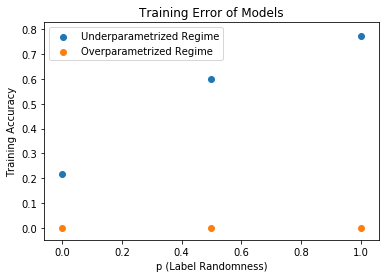

In [11]:
plt.scatter([0, 0.5, 1], 1 - np.array(training_acc))
plt.scatter([0, 0.5, 1], 1 - np.array(training_acc2))
plt.title('Training Error of Models')
plt.xlabel('p (Label Randomness)')
plt.ylabel('Training Accuracy')
plt.legend(['Underparametrized Regime', 'Overparametrized Regime'])
plt.show()

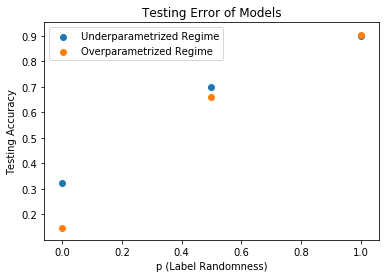

In [12]:
plt.scatter([0, 0.5, 1], 1 - np.array(testing_acc))
plt.scatter([0, 0.5, 1], 1 - np.array(testing_acc2))
plt.title('Testing Error of Models')
plt.xlabel('p (Label Randomness)')
plt.ylabel('Test Accuracy')
plt.legend(['Underparametrized Regime', 'Overparametrized Regime'])
plt.show()